## *Import libraries*

In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import pandas_profiling as pp
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns
import matplotlib.pyplot as plt

## *Import data*

In [18]:
%time
data_dir = 'data/'
train_df = pd.read_csv(data_dir+'train.csv')
test_df = pd.read_csv(data_dir+'test.csv')
sample_submission = pd.read_csv(data_dir+'sample_submission.csv')

Wall time: 0 ns


In [19]:
# combine into one DataSet
train_df['test'] = 0
test_df['test'] = 1
df = pd.concat([train_df, test_df], ignore_index=True)

## *Data review and analysis* 

In [20]:
df.head()

client_id   app_date education sex  age car car_type  decline_app_cnt  \
0      25905  01FEB2014       SCH   M   62   Y        Y                0   
1      63161  12MAR2014       SCH   F   59   N        N                0   
2      25887  01FEB2014       SCH   M   25   Y        N                2   
3      16222  23JAN2014       SCH   F   53   N        N                0   
4     101655  18APR2014       GRD   M   48   N        N                0   

   good_work  score_bki  bki_request_cnt  region_rating  home_address  \
0          0  -2.008753                1             50             1   
1          0  -1.532276                3             50             2   
2          0  -1.408142                1             80             1   
3          0  -2.057471                2             50             2   
4          1  -1.244723                1             60             2   

   work_address  income  sna  first_time foreign_passport  default  test  
0             2   18000    4           1                N      0.0     0  
1             3   19000    4           1                N      0.0     0  
2             2   30000    1           4                Y      0.0     0  
3             3   10000    1           3                N      0.0     0  
4             3   30000    1           4                Y      0.0     0

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

## *DataSet fields*


    client_id - идентификатор клиента
    education - уровень образования
    sex - пол заемщика
    age - возраст заемщика
    car - флаг наличия автомобиля
    car_type - флаг автомобиля иномарки
    decline_app_cnt - количество отказанных прошлых заявок
    good_work - флаг наличия “хорошей” работы
    bki_request_cnt - количество запросов в БКИ
    home_address - категоризатор домашнего адреса
    work_address - категоризатор рабочего адреса
    income - доход заемщика
    foreign_passport - наличие загранпаспорта
    sna - связь заемщика с клиентами банка
    first_time - давность наличия информации о заемщике
    score_bki - скоринговый балл по данным из БКИ
    region_rating - рейтинг региона
    app_date - дата подачи заявки
    default - флаг дефолта по кредиту


In [6]:
df_pp = pp.ProfileReport(df)
df_pp

Summarize dataset:   0%|          | 0/33 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [22]:
#separating the sample from the target variable 
X = df.drop('default', axis=1)
y = df['default'].dropna()

## *Primary data processing*

#### client_id - have the same meaning as the index number, will have no meaning for the model 

#### app_data - is a date in string format. Converting to date format for further generation of additional features

In [23]:
df['app_date'].unique()

array(['01FEB2014', '12MAR2014', '23JAN2014', '18APR2014', '18FEB2014',
       '04FEB2014', '17MAR2014', '14FEB2014', '10JAN2014', '03FEB2014',
       '08APR2014', '08JAN2014', '19MAR2014', '22JAN2014', '30JAN2014',
       '11MAR2014', '02FEB2014', '14APR2014', '06JAN2014', '24MAR2014',
       '15APR2014', '28FEB2014', '11FEB2014', '30MAR2014', '23MAR2014',
       '09MAR2014', '02MAR2014', '31JAN2014', '14MAR2014', '26JAN2014',
       '03APR2014', '22MAR2014', '11JAN2014', '17FEB2014', '13FEB2014',
       '17APR2014', '25FEB2014', '10APR2014', '01APR2014', '21APR2014',
       '20MAR2014', '03MAR2014', '25MAR2014', '24FEB2014', '16APR2014',
       '27FEB2014', '18MAR2014', '19FEB2014', '20FEB2014', '31MAR2014',
       '04MAR2014', '25JAN2014', '07JAN2014', '07MAR2014', '26MAR2014',
       '05FEB2014', '06MAR2014', '08FEB2014', '21JAN2014', '13MAR2014',
       '09JAN2014', '07FEB2014', '29JAN2014', '27JAN2014', '15FEB2014',
       '29APR2014', '04APR2014', '16JAN2014', '07APR2014', '13JA

In [24]:
#converting to DateTime format
df['app_date'] = pd.to_datetime(df['app_date'], format='%d%b%Y')

generating additional features:<br>
-season<br>
-month<br>
-weekend<br>

In [25]:
df['app_month'] = df['app_date'].apply(lambda x: x.month)

In [26]:
df['app_season']= df['app_date'].apply(lambda x: np.ceil(x.month/3.0))

In [27]:
df['app_weekend'] = df['app_date'].apply(lambda x: x.weekday()>=5)

#### education - categorical attribute, convert to numerical values

In [28]:
#fill null values with most popular blanks (or we can drop null values)
#df['education'] = df['education'].fillna('SCH')
df.dropna(subset=['education'], inplace=True)
#convert in accordance with the weight of the value (a dummy conversion is possible if it gives a better result)
df['education'] = df['education'].apply(lambda x: {'SCH':0, 
                                                       'GRD':1,
                                                       'UGR':2,
                                                       'PGR':3,
                                                       'ACD':4
                                                      }.get(x, 0))

#### sex, car, car_type, good_work, foreign_passport - binary attributes

In [35]:
#group binary attributes
bool_var = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'app_weekend']
#encode target values as 0 and 1
le = LabelEncoder()
for item in bool_var:
    df[item] = le.fit_transform(df[item])

#### age, decline_app_cnt, score_bki, bki_request_cnt, region_rating, income - numeratic attributes

In [63]:
#group numeratic attributes
num_var = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'region_rating', 'income']

c:\users\valeriy.vasipov\documents\datascience\venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


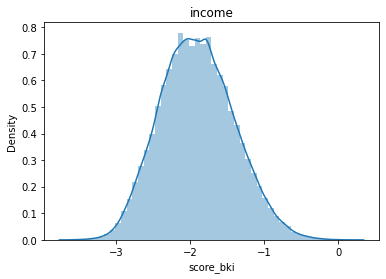

In [64]:
plt.figure()
sns.distplot(df['score_bki'])
plt.title(item)
plt.show()

c:\users\valeriy.vasipov\documents\datascience\venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


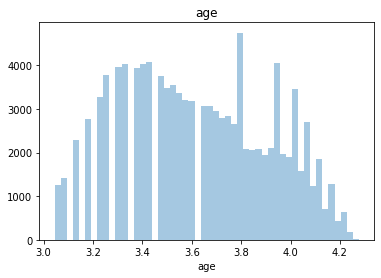

c:\users\valeriy.vasipov\documents\datascience\venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


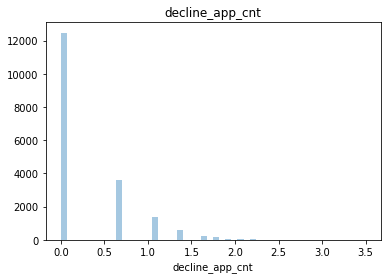

c:\users\valeriy.vasipov\documents\datascience\venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


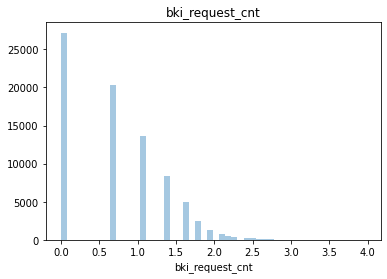

c:\users\valeriy.vasipov\documents\datascience\venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


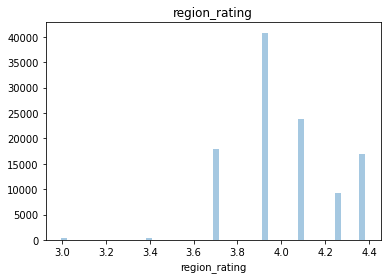

c:\users\valeriy.vasipov\documents\datascience\venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


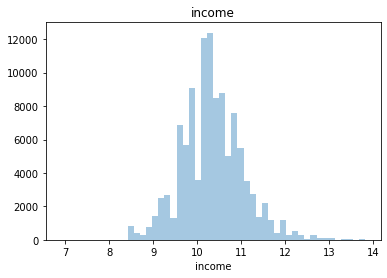

In [65]:
#logotyping of features
for item in ['age', 'decline_app_cnt', 'bki_request_cnt', 'region_rating', 'income']:
    plt.figure()
    sns.distplot(np.log(df[item][df[item] > 0].dropna()), kde = False, rug=False)
    plt.title(item)
    plt.show()

In [67]:
#Standardize numeratic features
ss = StandardScaler()
X_num = ss.fit_transform(df[num_var])

#### app_month, app_season, app_weekend, education, home_address, work_address, sna, first_time - categorial values

In [72]:
#group categorial attributes
cat_var = ['app_month', 'app_season', 'app_weekend', 'education', 'home_address', 'work_address',
           'sna', 'first_time']

<AxesSubplot:>

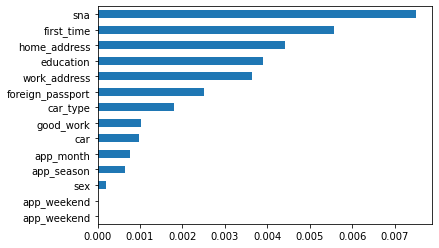

In [82]:
#assessment of the significance of categorical features
imp_cat = pd.Series(mutual_info_classif(df[bool_var+cat_var][df['test']==0], df['default'].dropna(), discrete_features=True),
          index=bool_var+cat_var)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109670 entries, 0 to 110147
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   client_id         109670 non-null  int64         
 1   app_date          109670 non-null  datetime64[ns]
 2   education         109670 non-null  int64         
 3   sex               109670 non-null  int64         
 4   age               109670 non-null  int64         
 5   car               109670 non-null  int64         
 6   car_type          109670 non-null  int64         
 7   decline_app_cnt   109670 non-null  int64         
 8   good_work         109670 non-null  int64         
 9   score_bki         109670 non-null  float64       
 10  bki_request_cnt   109670 non-null  int64         
 11  region_rating     109670 non-null  int64         
 12  home_address      109670 non-null  int64         
 13  work_address      109670 non-null  int64         
 14  inco